Dependencies

In [10]:
!pip install contractions 
!pip install textsearch

In [11]:
import contractions
import nltk                     
nltk.download('punkt')      
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import re

from gensim.models import FastText
from sklearn.metrics.pairwise import cosine_similarity
import torch

MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/NLP_anime_recommender_system/model/anime_recommender.bin"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP_anime_recommender_system/input/animes.csv')

df.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [13]:
df = df[['title', 'synopsis', 'genre','members', 'popularity', 'ranked', 'score', 'img_url']]
df.synopsis.fillna(np.nan, inplace=True)
df.ranked.fillna('', inplace = True)
df.score.fillna('', inplace = True)
df.img_url.fillna('https://static.zerochan.net/Eucliwood.Hellscythe.full.1091523.jpg', inplace=True)
df['description'] = df['genre'].map(str) + ' ' + df['synopsis']
df.dropna(inplace=True)
df = df.sort_values(by=['popularity'], ascending=False)
df.nunique()

title          15451
synopsis       15194
genre           4782
members         8664
popularity     13742
ranked         13869
score            578
img_url        15313
description    15315
dtype: int64

In [14]:
df = df.drop_duplicates(subset='title', keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15451 entries, 14596 to 17762
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        15451 non-null  object
 1   synopsis     15451 non-null  object
 2   genre        15451 non-null  object
 3   members      15451 non-null  int64 
 4   popularity   15451 non-null  int64 
 5   ranked       15451 non-null  object
 6   score        15451 non-null  object
 7   img_url      15451 non-null  object
 8   description  15451 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.2+ MB


In [15]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)

15451

In [40]:
tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, size=300, window=30, min_count=2, workers=4, sg=1, iter=50)

In [41]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [42]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 300)
doc_vecs_ft.shape

(15451, 300)

In [43]:
doc_sim = cosine_similarity(doc_vecs_ft)
doc_sim_df = pd.DataFrame(doc_sim)
doc_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,15411,15412,15413,15414,15415,15416,15417,15418,15419,15420,15421,15422,15423,15424,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434,15435,15436,15437,15438,15439,15440,15441,15442,15443,15444,15445,15446,15447,15448,15449,15450
0,1.000000,0.511393,0.458901,0.433547,0.486110,0.567950,0.475941,0.600612,0.543992,0.530898,0.517216,0.593246,0.573734,0.612499,0.543382,0.538620,0.448140,0.474354,0.421918,0.491275,0.457431,0.471384,0.436792,0.411461,0.371455,0.377094,0.380454,0.459278,0.505485,0.415741,0.530486,0.432505,0.413782,0.467859,0.427552,0.458904,0.514844,0.454130,0.450405,0.440299,...,0.581695,0.570494,0.547029,0.542057,0.545936,0.587552,0.555255,0.541767,0.534722,0.488979,0.564195,0.512512,0.559392,0.572119,0.575139,0.520442,0.553486,0.534088,0.571727,0.547624,0.544225,0.563042,0.518919,0.554729,0.563220,0.534530,0.577334,0.559595,0.555394,0.555248,0.475714,0.490613,0.558768,0.534899,0.545694,0.596299,0.568621,0.541538,0.524809,0.608622
1,0.511393,1.000000,0.498475,0.557220,0.609734,0.560344,0.634152,0.595132,0.549576,0.562413,0.657602,0.650355,0.571337,0.615368,0.578435,0.608799,0.498234,0.521669,0.458726,0.506713,0.566334,0.499299,0.503415,0.421709,0.432787,0.450570,0.423238,0.602676,0.592635,0.448225,0.620315,0.403406,0.469617,0.511686,0.467454,0.515065,0.529130,0.508846,0.440741,0.475388,...,0.573015,0.600769,0.648299,0.575257,0.638875,0.598003,0.548821,0.542481,0.622852,0.550902,0.584867,0.623263,0.593681,0.600628,0.583867,0.577402,0.649343,0.526839,0.593051,0.625938,0.571993,0.628462,0.729278,0.598917,0.616099,0.582357,0.567071,0.598798,0.555479,0.578945,0.569164,0.591533,0.667152,0.561397,0.608352,0.614720,0.594101,0.786561,0.619099,0.615456
2,0.458901,0.498475,1.000000,0.585697,0.490836,0.613572,0.493943,0.476058,0.512201,0.511039,0.660819,0.481722,0.467183,0.510500,0.521286,0.646398,0.436820,0.568098,0.547097,0.531912,0.438935,0.434839,0.440254,0.424186,0.403526,0.403813,0.445973,0.457177,0.547412,0.391444,0.493147,0.416600,0.434675,0.463141,0.438133,0.503631,0.507355,0.392948,0.411051,0.443132,...,0.493404,0.492148,0.524020,0.464434,0.507990,0.515149,0.500813,0.449721,0.475844,0.502889,0.579601,0.445419,0.554457,0.520722,0.476041,0.480722,0.492817,0.482210,0.590912,0.507775,0.465445,0.555594,0.425838,0.505567,0.533529,0.503734,0.555019,0.510669,0.537534,0.451837,0.474721,0.488475,0.502922,0.442946,0.491379,0.503516,0.478127,0.466829,0.529266,0.487177
3,0.433547,0.557220,0.585697,1.000000,0.519658,0.557175,0.511616,0.519834,0.520442,0.492678,0.587207,0.497207,0.517416,0.478344,0.539429,0.559909,0.378350,0.547549,0.488726,0.420738,0.432661,0.439165,0.448074,0.405684,0.388011,0.398319,0.395967,0.484532,0.553087,0.453190,0.497128,0.402860,0.419097,0.483390,0.427510,0.464501,0.474218,0.437965,0.386584,0.506222,...,0.529627,0.510604,0.513796,0.466066,0.529426,0.495170,0.465884,0.454090,0.501672,0.469239,0.497079,0.465683,0.485841,0.538521,0.475615,0.498084,0.498424,0.449816,0.508973,0.498146,0.457189,0.538275,0.483391,0.511444,0.545262,0.517900,0.545039,0.516661,0.481539,0.481995,0.510112,0.485325,0.566214,0.494097,0.484832,0.536369,0.485476,0.506222,0.472213,0.497195
4,0.486110,0.609734,0.490836,0.519658,1.000000,0.569720,0.589274,0.532760,0.474645,0.493118,0.652311,0.535720,0.418913,0.545770,0.496198,0.645898,0.557754,0.514901,0.469149,0.581195,0.497894,0.552531,0.515198,0.462514,0.471530,0.466661,0.460856,0.480145,0.624566,0.404024,0.482603,0.410712,0.479974,0.477174,0.496132,0.536595,0.516431,0.476610,0.441983,0.451348,...,0.511351,0.607711,0.520217,0.509351,0.571114,0.549551,0.520935,0.677162,0.549699,0.514132,0.548623,0.561276,0.544579,0.576136,0.575512,0.515922,0.547489,0.477100,0.545878,0.496401,0.485732,0.556617,0.553386,0.476980,0.516588,0.483975,0.506992,0.554731,0.532906,0.519323,0.470631,0.526536,0.572293,0.506963,0.585707,0.530577,0.538251,0.574857,0.552882,0.627271


In [49]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/NLP_anime_recommender_system/model/cosine_similarity.csv')

In [44]:
movies_list = df['title'].values
movies_list, movies_list.shape

(array(['Yuukoku no Moriarty',
        'Sword Art Online: Alicization - War of Underworld 2nd Season',
        'Shokugeki no Souma: Gou no Sara', ..., 'Sword Art Online',
        'Shingeki no Kyojin', 'Death Note'], dtype=object), (15451,))

In [45]:
import matplotlib.pyplot as plt
from IPython.display import Image

def anime_recommend(title):
    movie_idx = np.where(movies_list == title)[0][0]
    movie_similarities = doc_sim_df.iloc[movie_idx].values
    similar_movie_idxs = np.argsort(-movie_similarities)[1:6]
    print(similar_movie_idxs)
    display(Image(df.img_url.iloc[movie_idx]))
    print(movies_list[movie_idx])
    print(df.synopsis.iloc[movie_idx])
    for i in similar_movie_idxs:
        display(Image(df.img_url.iloc[i]))
        print(movies_list[i])
        print(df.synopsis.iloc[i])
    print(movie_similarities)

[14872 15332 12853 14830 15309]


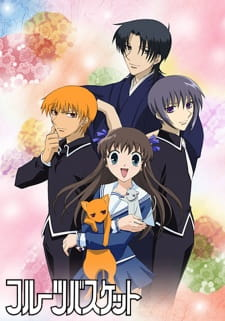

Fruits Basket
After the accident in which she lost her mother, 16-year-old Tooru moves in with her grandfather, but due to his home being renovated, is unable to continue living with him. Claiming she will find someone to stay with but also fearing the criticism of her family and not wanting to burden any of her friends, Tooru resorts to secretly living on her own in a tent in the woods. 
 
One night on her way back from work, she finds her tent buried underneath a landslide. Yuki Souma, the "prince" of her school, and his cousin Shigure Souma, a famous author, stumble across Tooru's situation and invite her to stay with them until her grandfather’s home renovations are complete. 
 
Upon arriving at the Souma house, Tooru discovers their secret: if a Souma is hugged by someone of the opposite gender, they temporarily transform into one of the animals of the zodiac! However, this strange phenomenon is no laughing matter; rather, it is a terrible curse that holds a dark history. As she c

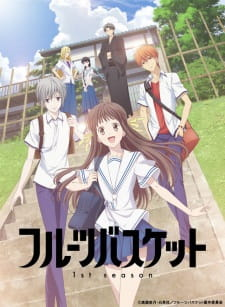

Fruits Basket 1st Season
Tooru Honda has always been fascinated by the story of the Chinese Zodiac that her beloved mother told her as a child. However, a sudden family tragedy changes her life, and subsequent circumstances leave her all alone. Tooru is now forced to live in a tent, but little does she know that her temporary home resides on the private property of the esteemed Souma family. Stumbling upon their home one day, she encounters Shigure, an older Souma cousin, and Yuki, the "prince" of her school. Tooru explains that she lives nearby, but the Soumas eventually discover her well-kept secret of being homeless when they see her walking back to her tent one night. 
 
Things start to look up for Tooru as they kindly offer to take her in after hearing about her situation. But soon after, she is caught up in a fight between Yuki and his hot-tempered cousin, Kyou. While trying to stop them, she learns that the Souma family has a well-kept secret of their own: whenever they are hugg

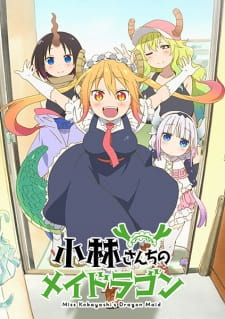

Kobayashi-san Chi no Maid Dragon
As Kobayashi sets off for another day at work, she opens her apartment door only to be met by an unusually frightening sight—the head of a dragon, staring at her from across the balcony. The dragon immediately transforms into a cute, busty, and energetic young girl dressed in a maid outfit, introducing herself as Tooru. 
 
It turns out that the stoic programmer had come across the dragon the previous night on a drunken excursion to the mountains, and since the mythical beast had nowhere else to go, she had offered the creature a place to stay in her home. Thus, Tooru had arrived to cash in on the offer, ready to repay her savior's kindness by working as her personal maidservant. Though deeply regretful of her words and hesitant to follow through on her promise, a mix of guilt and Tooru's incredible dragon abilities convinces Kobayashi to take the girl in. 
 
Despite being extremely efficient at her job, the maid's unorthodox methods of housekeeping ofte

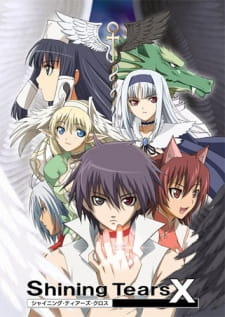

Shining Tears X Wind
Mysterious disappearances are occurring one after the other in Tatsumi Town. Kiriya has a vision from a mysterious beautiful girl with pointy ears. A book talking for an alternative world is found. And Mao searching for her long lost friend, Zero, comes to our world. But what she didn’t expect is to find Souma and Kureha, and even less, to accidentally take them to her world. Now, Souma and Kureha have to find a way to come back. But other forces are playing their part in the darkness and Souma with Kureha will find that going back is harder than they first anticipated. 
 
(Source: ANN) 


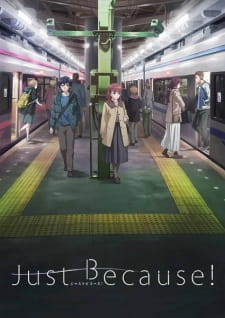

Just Because!
As another school year begins drawing to a close, the third-year high school students move steadily toward the next milestone of their lives: graduation. Among them are Mio Natsume, a girl burdened with lingering feelings; Hazuki Morikawa, a member of the concert band but distant from the others; and Haruto Souma, an athlete obsessed with baseball. Meanwhile, second-year student Ena Komiya seeks to revive the photography club to its former glory, refusing to let the organization be disbanded. Though this group lacks a strong connection with one another, their lives suddenly cross paths with the arrival of a third-year transfer student. 
 
While a transfer so close to graduation is unusual for most, it is business as usual for Eita Izumi. Due to his father's work, he has never been able to stay in one place for very long. But as luck would have it, their most recent relocation has returned Eita to his hometown for his final semester of high school. For better or worse, it 

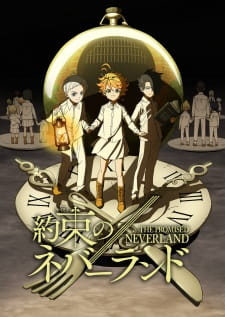

Yakusoku no Neverland
Surrounded by a forest and a gated entrance, the Grace Field House is inhabited by orphans happily living together as one big family, looked after by their "Mama," Isabella. Although they are required to take tests daily, the children are free to spend their time as they see fit, usually playing outside, as long as they do not venture too far from the orphanage—a rule they are expected to follow no matter what. However, all good times must come to an end, as every few months, a child is adopted and sent to live with their new family... never to be heard from again. 
 
However, the three oldest siblings have their suspicions about what is actually happening at the orphanage, and they are about to discover the cruel fate that awaits the children living at Grace Field, including the twisted nature of their beloved Mama. 
 
[Written by MAL Rewrite]
[0.5568441  0.54416836 0.66612478 ... 0.6224411  0.62886369 0.66766754]


In [46]:
anime_recommend('Fruits Basket')

In [51]:
!pip install -U Flask
!pip install flask-ngrok

Requirement already up-to-date: Flask in /usr/local/lib/python3.6/dist-packages (1.1.2)


In [3]:
import flask
from flask import Flask
from flask import request, render_template

import torch
import flask
import time
from flask import Flask
from flask import request

import functools
import torch.nn as nn
import joblib

from flask_ngrok import run_with_ngrok

In [8]:
cd /content/drive/My Drive/Colab Notebooks/NLP_anime_recommender_system

/content/drive/My Drive/Colab Notebooks/NLP_anime_recommender_system


In [17]:
app = Flask(__name__)     # initialize flask app
run_with_ngrok(app)
MODEL = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP_anime_recommender_system/model/cosine_similarity.csv")
DEVICE = "cpu"
memory = joblib.Memory("../input/", verbose=0)

@app.route("/")
def home():
  return render_template("index.html")

@memory.cache
def anime_recommender(title):
    movie_idx = np.where(movies_list == title)[0][0]
    movie_similarities = doc_sim_df.iloc[movie_idx].values
    similar_movie_idxs = np.argsort(-movie_similarities)[1:6]
    return similar_movie_idxs
    

@app.route("/predict", methods=['POST'])           
def predict():       
  title = [str(x) for x in request.form.values()]
  title = title[0]   
  start_time = time.time()
  similar_anime_titles = anime_recommender(title)
  similar_animes = []
  for x in similar_anime_titles:
    similar_animes.append(df.title.iloc[x])                   
  return render_template("index.html", title = r"Your Anime Title = '{}'".format(title),
    prediction_text="Similar Anime Titles are :", similar_titles_img= "https://cdn.myanimelist.net/images/anime/9/76662.jpg",
    similar_titles_str = similar_animes)

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://ccd32331f50a.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Jul/2020 23:04:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Jul/2020 23:04:58] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [12/Jul/2020 23:04:58] "GET /similar_titles_img HTTP/1.1" 404 -
127.0.0.1 - - [12/Jul/2020 23:04:59] "GET /width=150%22 HTTP/1.1" 404 -
127.0.0.1 - - [12/Jul/2020 23:05:00] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Jul/2020 23:05:01] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [12/Jul/2020 23:05:01] "GET /['Dungeon HTTP/1.1" 404 -
127.0.0.1 - - [12/Jul/2020 23:05:01] "GET /similar_titles_img HTTP/1.1" 404 -
